In [1]:
import pandas as pd
import numpy as np

# Filtrando os alertas
import warnings
warnings.filterwarnings('ignore')

# Biblioteca para visualização dos dados
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Comando para evitar alguns problemas na otimização bayesiana
np.int = int

# 1. Importando os dataset's

In [2]:
# Importação do dataset de treino
df_train = pd.read_pickle('dataset/df_train.pkl')

# Setando as variaveis X e y de treino
X_train, y_train = df_train.drop('Reached_on_Time', axis=1), df_train['Reached_on_Time']

# Importação do dataset de teste
df_test = pd.read_pickle('dataset/df_test.pkl')

# Setando as variaveis X e y de teste
X_test, y_test = df_test.drop('Reached_on_Time', axis=1), df_test['Reached_on_Time']

In [3]:
# Visualizando dataset de treino
X_train

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Gender_F,Gender_M,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
0,4,1,261,2,1,9,4158,1,0,0,1,0,0,0,0,1,0
1,3,3,162,2,0,26,1659,1,0,0,0,1,0,0,0,0,1
2,3,2,221,2,1,9,4466,0,1,0,0,1,0,1,0,0,0
3,3,5,157,4,1,2,4640,1,0,0,0,1,0,0,0,1,0
4,2,5,272,2,0,24,3638,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794,4,4,204,3,0,9,4757,1,0,0,1,0,0,1,0,0,0
8795,4,2,237,3,0,7,4785,1,0,0,0,1,0,0,1,0,0
8796,4,1,140,4,0,6,5067,0,1,1,0,0,0,0,0,1,0
8797,4,4,251,2,1,6,4376,1,0,0,0,1,0,1,0,0,0


In [4]:
# Visualizando dataset de test
X_test

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Gender_F,Gender_M,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
0,4,5,268,3,0,59,2083,1,0,0,0,1,0,0,1,0,0
1,7,5,296,4,0,2,1823,1,0,0,0,1,1,0,0,0,0
2,3,5,139,2,0,2,5839,0,1,0,1,0,1,0,0,0,0
3,5,5,186,4,0,3,4287,0,1,0,1,0,1,0,0,0,0
4,3,3,149,4,0,2,5282,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,5,2,121,5,1,10,4790,1,0,0,0,1,0,0,1,0,0
2196,5,4,228,5,0,9,1549,1,0,0,1,0,0,0,0,1,0
2197,4,5,216,4,1,1,4458,1,0,0,0,1,0,0,0,1,0
2198,6,1,254,4,0,2,1071,1,0,0,0,1,0,0,0,1,0


In [5]:
# Verificando o desbalanceamento dos dados
pd.Series(y_train).value_counts(normalize=True).round(2)

Reached_on_Time
1    0.6
0    0.4
Name: proportion, dtype: float64

# 2. Modelagem

In [6]:
# Ferramentas que vamos utilizar na modelagem

# Tecnicas de sampling
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Pipeline do pacote imblearn para realização de tecnicas de Samplig (nossos dados são desbalanceados)
from imblearn.pipeline import Pipeline as ImbalancedPipeline

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Seleção das melhores features
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Validação Cruzada
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score, cross_val_predict

# Busca de Hiperparametros Bayesiana
from skopt import gp_minimize

# Metricas para avaliação
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [7]:
# Funções a utilizar

# Definindo qual sampler vamos utilizar
def return_sampling (type_sampling, SEED):

    if type_sampling == 'NearMiss': 
        sampling = NearMiss()
    elif type_sampling == 'SMOTE':
        sampling = SMOTE(random_state=SEED)
    elif type_sampling == 'RandomUnder':
        sampling = RandomUnderSampler(random_state=SEED)
    elif type_sampling == 'RandomOver':
        sampling = RandomOverSampler(random_state=SEED)
    else:
        sampling = None
        
    return sampling


# Definindo qual scaling vamos utilizar
def return_scaling (type_scaler):
    if type_scaler == 'StandardScaler':
        scaler = StandardScaler()
    elif type_scaler == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif type_scaler == 'RobustScaler':
        scaler = RobustScaler()
    else:
        scaler = None
        
    return scaler


# Definindo qual score_func do SelectKBest vamos utilizar
def return_score_func (type_score_func):
    # Definindo Funcao de score do SelectKBest
    if type_score_func == 'f_classif':
        score_func = f_classif
    elif type_score_func == 'mutual_info_classif':
        score_func = mutual_info_classif
        
    return score_func

## 2.1 KNN

In [8]:
# Importação do KNN
from sklearn.neighbors import KNeighborsClassifier

### 2.1.1 KNN (Baseline - Sem Hiperparametros)

In [9]:
# Criação do modelo
knn_model = KNeighborsClassifier()

# Treinamento
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn_base = knn_model.predict(X_test)

# Verificando a acuracia de Treino e Test
acc_train = knn_model.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred_knn_base)
auc_roc = roc_auc_score(y_test, y_pred_knn_base)

# Visualizando as acuracias
print("Acuracia de Treino: %.2f%%" % (acc_train * 100))
print("Acuracia de Teste: %.2f%%" % (acc_test * 100))
print("AUC-ROC: %.2f%%" % (auc_roc * 100))

Acuracia de Treino: 78.78%
Acuracia de Teste: 64.64%
AUC-ROC: 64.12%


### 2.1.2 KNN (Hiperparametros - Busca Otimizada Bayesiana)

In [10]:
# Funcao para buscar melhor modelo
def treinar_modelo_knn (params):
    try:
        # Definindo o random state
        SEED = 300
        
        # Setando os parametros
        n_neighbors = params[0]
        p = params[1]
        k = params[2]
        type_sampling = params[3]
        type_score_func = params[4]
        type_scaler = params[5]
        
        # Definindo o sampling
        sampling = return_sampling (type_sampling, SEED)
        
        # Definindo os scalings
        scaler = return_scaling (type_scaler)
 
        # Definindo a funcao do SelectKBest
        score_func = return_score_func (type_score_func)
                    
        # Verificando os parametros
        print(params)
        
        # Testando os melhores parametros no pipeline do knn
        knn_pipeline_best = ImbalancedPipeline([
            ('sampler', sampling),
            ('scaler', scaler),
            ('selector', SelectKBest(k=k, score_func=score_func)),
            ('classifier', KNeighborsClassifier(n_neighbors=n_neighbors, p=p))
        ])
        
        # Utilizando uma validação cruzada estratificada - por causa do modelo desbalanceado
        cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=SEED)
                
        # Realizando a validação cruzada dos modelos: procurando o melhor modelo com base na curva auc-roc
        y_probas = cross_val_predict(knn_pipeline_best, X_train, y_train, cv=cv, method='predict_proba')
        
        # Calculo das curvas auc-roc
        roc_auc = roc_auc_score(y_train, y_probas[:, 1])

        return -roc_auc

    except Exception as erro:
        # Aqui você imprime o erro
        print("Ocorreu um erro:", erro)
        return 1000.0

In [11]:
# Espaço para testar
space = [
    (3, 300), # n_neighbors
    (1, 2), # parametro p
    (1, 17), # parametro k
    (['NearMiss', 'SMOTE', 'RandomUnder', 'RandomOver']), # type_sampling
    (['f_classif', 'mutual_info_classif']), # type_score_func
    ([None, 'StandardScaler', 'MinMaxScaler', 'RobustScaler']), # type_scaler
]

In [12]:
%%time
# Procurar melhor resultado
resultado_gp = gp_minimize(treinar_modelo_knn, space, verbose=1, n_calls=100, n_random_starts=60, n_jobs=-1, random_state=0)

Iteration No: 1 started. Evaluating function at random point.
[179, 2, 15, 'SMOTE', 'mutual_info_classif', 'StandardScaler']
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.7969
Function value obtained: -0.7092
Current minimum: -0.7092
Iteration No: 2 started. Evaluating function at random point.
[91, 1, 5, 'RandomOver', 'mutual_info_classif', 'StandardScaler']
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.0966
Function value obtained: -0.7341
Current minimum: -0.7341
Iteration No: 3 started. Evaluating function at random point.
[120, 2, 6, 'RandomUnder', 'f_classif', 'RobustScaler']
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6996
Function value obtained: -0.7263
Current minimum: -0.7341
Iteration No: 4 started. Evaluating function at random point.
[45, 2, 9, 'RandomUnder', 'mutual_info_classif', 'MinMaxScaler']
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6165
Function value obtained: -0.

Iteration No: 33 ended. Evaluation done at random point.
Time taken: 5.1042
Function value obtained: -0.7343
Current minimum: -0.7395
Iteration No: 34 started. Evaluating function at random point.
[20, 1, 15, 'SMOTE', 'mutual_info_classif', 'MinMaxScaler']
Iteration No: 34 ended. Evaluation done at random point.
Time taken: 5.6003
Function value obtained: -0.7025
Current minimum: -0.7395
Iteration No: 35 started. Evaluating function at random point.
[257, 2, 9, 'RandomUnder', 'mutual_info_classif', 'MinMaxScaler']
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 3.9586
Function value obtained: -0.7108
Current minimum: -0.7395
Iteration No: 36 started. Evaluating function at random point.
[142, 1, 16, 'NearMiss', 'f_classif', 'RobustScaler']
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 2.4135
Function value obtained: -0.7008
Current minimum: -0.7395
Iteration No: 37 started. Evaluating function at random point.
[272, 2, 6, 'RandomUnder', 'f_cl

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 5.9806
Function value obtained: -0.7402
Current minimum: -0.7455
Iteration No: 66 started. Searching for the next optimal point.
[300, 1, 15, 'NearMiss', 'mutual_info_classif', None]
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 6.0996
Function value obtained: -0.7270
Current minimum: -0.7455
Iteration No: 67 started. Searching for the next optimal point.
[286, 2, 1, 'SMOTE', 'f_classif', None]
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 3.0905
Function value obtained: -0.6883
Current minimum: -0.7455
Iteration No: 68 started. Searching for the next optimal point.
[300, 1, 4, 'RandomUnder', 'mutual_info_classif', 'MinMaxScaler']
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 4.8484
Function value obtained: -0.7327
Current minimum: -0.7455
Iteration No: 69 started. Searching for the next optimal point.
[133

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 4.4666
Function value obtained: -0.7436
Current minimum: -0.7455
Iteration No: 98 started. Searching for the next optimal point.
[300, 2, 17, 'RandomOver', 'f_classif', None]
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 3.5735
Function value obtained: -0.7404
Current minimum: -0.7455
Iteration No: 99 started. Searching for the next optimal point.
[300, 1, 12, 'NearMiss', 'mutual_info_classif', 'RobustScaler']
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 6.6759
Function value obtained: -0.7121
Current minimum: -0.7455
Iteration No: 100 started. Searching for the next optimal point.
[300, 1, 17, 'NearMiss', 'f_classif', 'StandardScaler']
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 4.2448
Function value obtained: -0.7075
Current minimum: -0.7455
CPU times: total: 5min 1s
Wall time: 6min 6s


In [13]:
# Verificando melhores resultados
best_params = resultado_gp.x

# Visualizando
best_params

[126, 1, 9, 'RandomUnder', 'mutual_info_classif', None]

In [14]:
# Reconfigurar as mesmas configurações

# Ponto de aleatoriedade
SEED = 300
np.random.seed(SEED)

# Selecionando o melhor modelo com base nos parametros
n_neighbors = best_params[0]
p = best_params[1]
k = best_params[2]
sampling = return_sampling (best_params[3], SEED)
score_func = return_score_func (best_params[4])
scaler = return_scaling (best_params[5])


# Repassando os parametros para o pipeline do knn
knn_pipeline_best = ImbalancedPipeline([
    ('sampler', sampling),
    ('scaler', scaler),
    ('selector', SelectKBest(k=k, score_func=score_func)),
    ('classifier', KNeighborsClassifier(n_neighbors=n_neighbors, p=p))
])

# Utilizando a mesma validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=SEED)

# Verificando se estamos com o mesmo modelo
y_probas = cross_val_predict(knn_pipeline_best, X_train, y_train, cv=cv, method='predict_proba')

# Treinamento do modelo
knn_pipeline_best.fit(X_train, y_train)

# Predict dos modelos
y_pred_knn_otimizado = knn_pipeline_best.predict(X_test)

# Calculo das curvas auc-roc
roc_auc = roc_auc_score(y_train, y_probas[:, 1])

# Verificando a acuracia de Treino e Test
acc_train = knn_pipeline_best.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred_knn_otimizado)
         
# Visualizando as acuracias e curva roc
print("Acuracia de Treino: %.2f%%" % (acc_train * 100))
print("Acuracia de Teste: %.2f%%" % (acc_test * 100))
print(f'Score AUC-ROC: {round(roc_auc, 4) * 100}%')

Acuracia de Treino: 68.41%
Acuracia de Teste: 67.50%
Score AUC-ROC: 74.56%


### 2.1.3 KNN - Conclusão

In [15]:
print("RELATÓRIO DO KNN CLASSIFICAÇÃO:\n\n")
print("Modelo Sem Hiperparametros:\n")
print(classification_report(y_test, y_pred_knn_base))
print("--------------------------------------------------------\n")
print("Modelo Com Hiperparametros:\n")
print(classification_report(y_test, y_pred_knn_otimizado))

RELATÓRIO DO KNN CLASSIFICAÇÃO:


Modelo Sem Hiperparametros:

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       887
           1       0.72      0.67      0.69      1313

    accuracy                           0.65      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.65      0.65      0.65      2200

--------------------------------------------------------

Modelo Com Hiperparametros:

              precision    recall  f1-score   support

           0       0.55      0.99      0.71       887
           1       0.98      0.46      0.63      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.67      2200
weighted avg       0.81      0.68      0.66      2200



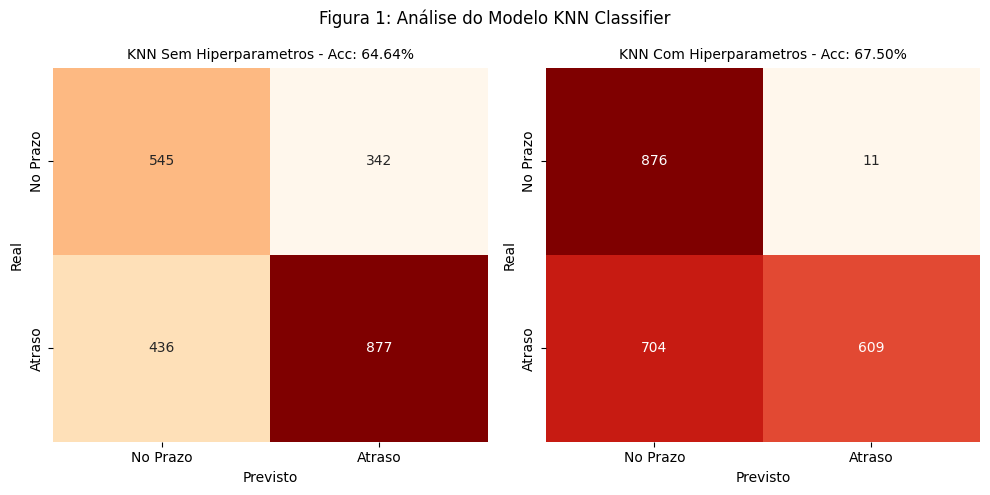

In [16]:
# Plotando a matriz de confusao - Sem Hiperparametros
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# Plotando a matriz de confusao
sns.heatmap(confusion_matrix(y_test, y_pred_knn_base), cmap='OrRd', annot=True, fmt='2.0f', 
              xticklabels=['No Prazo', 'Atraso'], yticklabels=['No Prazo', 'Atraso'], ax=axs[0], cbar=False)

acc = accuracy_score(y_test, y_pred_knn_base).round(4)
axs[0].set_title('KNN Sem Hiperparametros - Acc: %.2f%%' % (acc*100), fontsize=10)
axs[0].set_ylabel('Real')
axs[0].set_xlabel('Previsto')

# Plotando a matriz de confusao - Com Hiperparametros
sns.heatmap(confusion_matrix(y_test, y_pred_knn_otimizado), cmap='OrRd', annot=True, fmt='2.0f', 
              xticklabels=['No Prazo', 'Atraso'], yticklabels=['No Prazo', 'Atraso'], ax=axs[1], cbar=False)

acc = accuracy_score(y_test, y_pred_knn_otimizado).round(4)
axs[1].set_title('KNN Com Hiperparametros - Acc: %.2f%%' % (acc*100), fontsize=10)
axs[1].set_ylabel('Real')
axs[1].set_xlabel('Previsto')

# Titulo da figura
fig.suptitle('Figura 1: Análise do Modelo KNN Classifier', fontsize=12)

plt.tight_layout()

plt.show()

**Sobre a Figura**

Este gráfico juntamente com o relatório mostra que a predição da classe 1 (Em Atraso) se sai muito bem, e no notebook 1 de Visão Geral na parte de Análise Descritiva seção 2.2.9 e 2.2.10 mostra que esta classe ela tinha um comportamento fácil de prever. Entretanto, a classe 0 (No Prazo) era mais dificil de prever, visto que o comportamento era um pouco mais misturado. 

Além disso a Classe 1 tem mais registros, e o dataset está desbalanceado, ou seja, vendo a diferença das métricas de treino e teste no modelo Sem Hiperparametros indica que o modelo sofreu de **overfitting**, algo que não ocorre no segundo modelo com hiperparametro, visto que, as medidas de treino e teste são parecidas.

De qualquer forma, o modelo não se saiu bem, muito por conta de não conseguir prever a classe 0 de forma correta.

## 2.2 Decision Tree

In [17]:
# Importação do Decision Tree
from sklearn.tree import DecisionTreeClassifier

### 2.2.1 Decision Tree (Baseline - Sem Hiperparametros)

In [18]:
# SEED
SEED = 300

# Criação do modelo
tree_model = DecisionTreeClassifier(random_state=SEED)

# Treinamento
tree_model.fit(X_train, y_train)

# Predict
y_pred_tree_base = tree_model.predict(X_test)

# Verificando a acuracia de Treino e Test
acc_train = tree_model.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred_tree_base)
auc_roc = roc_auc_score(y_test, y_pred_tree_base)

# Visualizando as acuracias
print("Acuracia de Treino: %.2f%%" % (acc_train * 100))
print("Acuracia de Teste: %.2f%%" % (acc_test * 100))
print("AUC-ROC: %.2f%%" % (auc_roc * 100))

Acuracia de Treino: 100.00%
Acuracia de Teste: 64.23%
AUC-ROC: 62.42%


### 2.2.2 Decision Tree (Hiperparametros - Busca Otimizada Bayesiana)

In [19]:
# Funcao para buscar melhor modelo
def treinar_modelo_tree (params):
    try:
        # Definindo o random state
        SEED = 300
        
        # Setando os parametros
        criterion = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]
        class_weight = params[4]
        type_sampling = params[5]
        
        
        # Definindo o sampling
        sampling = return_sampling (type_sampling, SEED)
        
        # Caso o max_depth venha com o valor 0, ele irá atribuir como None valor default
        max_depth = None if max_depth == 0 else max_depth
        
        # Verificando os parametros
        print(params)
        
        # Testando os melhores parametros no pipeline do knn
        tree_pipeline_best = ImbalancedPipeline([
            ('sampler', sampling),
            ('classifier', DecisionTreeClassifier(criterion=criterion,max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                max_features=max_features, class_weight=class_weight, random_state=SEED))
        ])
        
        # Utilizando uma validação cruzada estratificada - por causa do modelo desbalanceado
        cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=SEED)
                
        # Realizando a validação cruzada dos modelos: procurando o melhor modelo com base na curva auc-roc
        y_probas = cross_val_predict(tree_pipeline_best, X_train, y_train, cv=cv, method='predict_proba')
        
        # Calculo das curvas auc-roc
        roc_auc = roc_auc_score(y_train, y_probas[:, 1])

        return -roc_auc
        
    except Exception as erro:
        print(erro)
        return 1000.0

In [20]:
# Espaço para testar
space = [
    (['gini', 'entropy']), # criterion
    (0, 600), # max_depth
    (1, 100), # min_samples_leaf
    ([None, 'log2', 'sqrt']), # max_features
    ([None, 'balanced']), # class_weight
    (['NearMiss', 'SMOTE', 'RandomUnder', 'RandomOver']), # type_sampling = params[4]
]

In [21]:
%%time
# Procurar melhor resultado
resultado_gp = gp_minimize(treinar_modelo_tree, space, verbose=1, n_calls=100, n_random_starts=60, n_jobs=-1, random_state=0)

Iteration No: 1 started. Evaluating function at random point.
['gini', 507, 86, 'sqrt', 'balanced', 'RandomOver']
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1321
Function value obtained: -0.7312
Current minimum: -0.7312
Iteration No: 2 started. Evaluating function at random point.
['entropy', 34, 28, 'log2', 'balanced', 'RandomOver']
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1180
Function value obtained: -0.7292
Current minimum: -0.7312
Iteration No: 3 started. Evaluating function at random point.
['entropy', 502, 34, 'log2', None, 'SMOTE']
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0084
Function value obtained: -0.7252
Current minimum: -0.7312
Iteration No: 4 started. Evaluating function at random point.
['entropy', 522, 48, 'sqrt', 'balanced', 'RandomUnder']
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0856
Function value obtained: -0.7370
Current minimum: -0.7370
Iteration No: 

Iteration No: 36 ended. Evaluation done at random point.
Time taken: 1.0540
Function value obtained: -0.7374
Current minimum: -0.7439
Iteration No: 37 started. Evaluating function at random point.
['gini', 387, 33, 'log2', None, 'RandomOver']
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.1115
Function value obtained: -0.7292
Current minimum: -0.7439
Iteration No: 38 started. Evaluating function at random point.
['entropy', 531, 68, 'log2', None, 'RandomUnder']
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.0790
Function value obtained: -0.7257
Current minimum: -0.7439
Iteration No: 39 started. Evaluating function at random point.
['entropy', 528, 32, 'sqrt', None, 'RandomUnder']
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.0775
Function value obtained: -0.7240
Current minimum: -0.7439
Iteration No: 40 started. Evaluating function at random point.
['entropy', 438, 65, None, None, 'RandomUnder']
Iteration No: 40 e

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 2.2096
Function value obtained: -0.7325
Current minimum: -0.7439
Iteration No: 70 started. Searching for the next optimal point.
['gini', 360, 33, None, None, 'SMOTE']
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 2.1979
Function value obtained: -0.7365
Current minimum: -0.7439
Iteration No: 71 started. Searching for the next optimal point.
['entropy', 572, 51, None, 'balanced', 'RandomUnder']
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.1847
Function value obtained: -0.7413
Current minimum: -0.7439
Iteration No: 72 started. Searching for the next optimal point.
['gini', 147, 20, None, 'balanced', 'RandomUnder']
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.1507
Function value obtained: -0.7411
Current minimum: -0.7439
Iteration No: 73 started. Searching for the next optimal point.
['gini', 573, 100, N

In [22]:
# Verificando melhores resultados
best_params = resultado_gp.x

# Visualizando
best_params

['gini', 349, 17, None, None, 'RandomOver']

In [23]:
# Reconfigurar as mesmas configurações

# Ponto de aleatoriedade
SEED = 300

# Selecionando o melhor modelo com base nos parametros
criterion = best_params[0]
max_depth = best_params[1]
min_samples_leaf = best_params[2]
max_features = best_params[3]
class_weight = best_params[4]
sampling = return_sampling (best_params[5], SEED)

# Repassando os parametros para o pipeline do knn
tree_pipeline_best = ImbalancedPipeline([
    ('sampler', sampling),
    ('classifier', DecisionTreeClassifier(criterion=criterion,max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                            max_features=max_features, class_weight=class_weight, random_state=SEED))
])

# Utilizando a mesma validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=SEED)

# Verificando se estamos com o mesmo modelo
y_probas = cross_val_predict(tree_pipeline_best, X_train, y_train, cv=cv, method='predict_proba')

# Treinamento do modelo
tree_pipeline_best.fit(X_train, y_train)

# Predict dos modelos
y_pred_tree_otimizado = tree_pipeline_best.predict(X_test)

# Calculo das curvas auc-roc
roc_auc = roc_auc_score(y_train, y_probas[:, 1])

# Verificando a acuracia de Treino e Test
acc_train = tree_pipeline_best.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred_tree_otimizado)
         
# Visualizando as acuracias e curva roc
print("Acuracia de Treino: %.2f%%" % (acc_train * 100))
print("Acuracia de Teste: %.2f%%" % (acc_test * 100))
print(f'Score AUC-ROC: {round(roc_auc, 4) * 100}%')

Acuracia de Treino: 76.25%
Acuracia de Teste: 65.86%
Score AUC-ROC: 74.64%


### 2.2.3 Decision Tree - Conclusão

In [24]:
print("RELATÓRIO DO DECISION TREE CLASSIFICAÇÃO:\n\n")
print("Modelo Sem Hiperparametros:\n")
print(classification_report(y_test, y_pred_tree_base))
print("--------------------------------------------------------\n")
print("Modelo Com Hiperparametros:\n")
print(classification_report(y_test, y_pred_tree_otimizado))

RELATÓRIO DO DECISION TREE CLASSIFICAÇÃO:


Modelo Sem Hiperparametros:

              precision    recall  f1-score   support

           0       0.56      0.53      0.54       887
           1       0.69      0.72      0.71      1313

    accuracy                           0.64      2200
   macro avg       0.63      0.62      0.63      2200
weighted avg       0.64      0.64      0.64      2200

--------------------------------------------------------

Modelo Com Hiperparametros:

              precision    recall  f1-score   support

           0       0.56      0.71      0.63       887
           1       0.76      0.62      0.69      1313

    accuracy                           0.66      2200
   macro avg       0.66      0.67      0.66      2200
weighted avg       0.68      0.66      0.66      2200



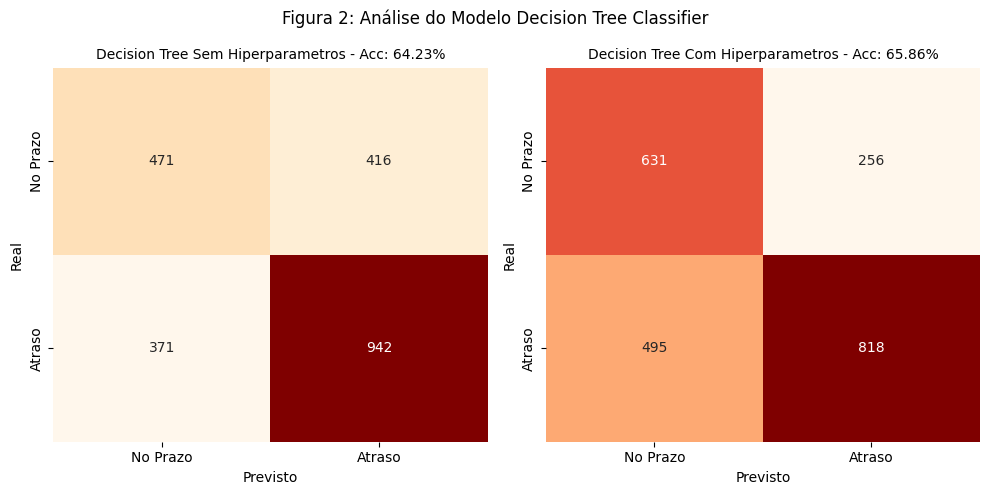

In [25]:
# Plotando a matriz de confusao - Sem Hiperparametros
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# Plotando a matriz de confusao
sns.heatmap(confusion_matrix(y_test, y_pred_tree_base), cmap='OrRd', annot=True, fmt='2.0f', 
              xticklabels=['No Prazo', 'Atraso'], yticklabels=['No Prazo', 'Atraso'], ax=axs[0], cbar=False)

acc = accuracy_score(y_test, y_pred_tree_base).round(4)
axs[0].set_title('Decision Tree Sem Hiperparametros - Acc: %.2f%%' % (acc*100), fontsize=10)
axs[0].set_ylabel('Real')
axs[0].set_xlabel('Previsto')

# Plotando a matriz de confusao - Com Hiperparametros
sns.heatmap(confusion_matrix(y_test, y_pred_tree_otimizado), cmap='OrRd', annot=True, fmt='2.0f', 
              xticklabels=['No Prazo', 'Atraso'], yticklabels=['No Prazo', 'Atraso'], ax=axs[1], cbar=False)

acc = accuracy_score(y_test, y_pred_tree_otimizado).round(4)
axs[1].set_title('Decision Tree Com Hiperparametros - Acc: %.2f%%' % (acc*100), fontsize=10)
axs[1].set_ylabel('Real')
axs[1].set_xlabel('Previsto')

# Titulo da figura
fig.suptitle('Figura 2: Análise do Modelo Decision Tree Classifier', fontsize=12)

plt.tight_layout()

plt.show()

**Sobre a Figura**

O `modelo sem hiperparametro` claramente sofreu de **overfitting**. É nitido, o treino teve uma métrica de 100% ai no teste cai para 64%, esta diferença é um exemplo claro de overfitting, isto se deve pela profundidade da arvore, ela ficou muito ajustada ao dados de treino.

A respeito do `modelo com hiperparametro` ele não possui o problema de overfitting, mas ele também não conseguiu identificar de maneira correta os dados da classe 0 (No Prazo), o problema do modelo é o Falso-Positivo, isto é, o modelo prevê a entrega como no Prazo e na verdade ela é um atraso. 

Novamente observando os dados na Análise Descritiva a gente observa que é dificil diferenciar ou encontrar um padrão para dados no prazo, a classe 1 (Em Atraso) ela já tem um comportamento, e o modelo consegue identificar melhor as entregas em atraso. O Problema fica realmente em tentar prever entregas No Prazo.

O Modelo Decision Tree está parecido com o modelo KNN, sem muita diferença, ainda por conta da aleatoriedade do modelo decision tree.

## 2.3 Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

### 2.3.1 Random Forest (Baseline - Sem Hiperparametros)

In [27]:
# SEED
SEED = 300

# Criação do modelo
rf_model = RandomForestClassifier(random_state=SEED)

# Treinamento
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf_base = rf_model.predict(X_test)

# Verificando a acuracia de Treino e Test
acc_train = rf_model.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred_rf_base)
auc_roc = roc_auc_score(y_test, y_pred_rf_base)

# Visualizando as acuracias
print("Acuracia de Treino: %.2f%%" % (acc_train * 100))
print("Acuracia de Teste: %.2f%%" % (acc_test * 100))
print("AUC-ROC: %.2f%%" % (auc_roc * 100))

Acuracia de Treino: 100.00%
Acuracia de Teste: 65.32%
AUC-ROC: 65.99%


### 2.3.2 Random Forest (Hiperparametros - Busca Otimizada Bayesiana)

In [28]:
# Funcao para buscar melhor modelo
def treinar_modelo_rf (params):
    try:
        # Definindo o random state
        SEED = 300
        
        # Setando os parametros
        n_estimators = params[0]
        criterion = params[1]
        max_depth = params[2]
        min_samples_leaf = params[3]
        max_features = params[4]
        class_weight = params[5]
        type_sampling = params[6]
        
        
        # Definindo o sampling
        sampling = return_sampling (type_sampling, SEED)
        
        # Caso o max_depth venha com o valor 0, ele irá atribuir como None valor default
        max_depth = None if max_depth == 0 else max_depth
        
        # Verificando os parametros
        print(params)
        
        # Testando os melhores parametros no pipeline
        rf_pipeline_best = ImbalancedPipeline([
            ('sampler', sampling),
            ('classifier', RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                                  min_samples_leaf=min_samples_leaf, max_features=max_features, 
                                                  class_weight=class_weight, random_state=SEED, n_jobs=-1))
        ])
        
        # Utilizando uma validação cruzada estratificada - por causa do modelo desbalanceado
        cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=SEED)
                
        # Realizando a validação cruzada dos modelos: procurando o melhor modelo com base na curva auc-roc
        y_probas = cross_val_predict(rf_pipeline_best, X_train, y_train, cv=cv, method='predict_proba')
        
        # Calculo das curvas auc-roc
        roc_auc = roc_auc_score(y_train, y_probas[:, 1])

        return -roc_auc
        
    except:
        return 1000.0

In [29]:
# Espaço para testar
space = [
    (100, 2000), # n_estimators
    (['gini', 'entropy']), # criterion
    (0, 300), # max_depth
    (1, 100), # min_samples_leaf
    ([None, 'log2', 'sqrt']), # max_features
    ([None, 'balanced']), # class_weight
    (['NearMiss', 'SMOTE', 'RandomUnder', 'RandomOver']), # type_sampling
]

In [30]:
%%time
# Procurar melhor resultado --> score_func como f_classif
resultado_gp = gp_minimize(treinar_modelo_rf, space, verbose=1, n_calls=100, n_random_starts=60, n_jobs=-1, random_state=0)

Iteration No: 1 started. Evaluating function at random point.
[1226, 'gini', 257, 85, 'log2', None, 'RandomOver']
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.0410
Function value obtained: -0.7387
Current minimum: -0.7387
Iteration No: 2 started. Evaluating function at random point.
[208, 'entropy', 143, 81, 'log2', None, 'SMOTE']
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.3387
Function value obtained: -0.7384
Current minimum: -0.7387
Iteration No: 3 started. Evaluating function at random point.
[741, 'gini', 110, 96, None, 'balanced', 'RandomOver']
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.8119
Function value obtained: -0.7362
Current minimum: -0.7387
Iteration No: 4 started. Evaluating function at random point.
[1622, 'gini', 204, 72, 'log2', 'balanced', 'RandomUnder']
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.6738
Function value obtained: -0.7402
Current minimum: -0.7402
It

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 24.2400
Function value obtained: -0.7371
Current minimum: -0.7409
Iteration No: 35 started. Evaluating function at random point.
[454, 'gini', 224, 68, 'log2', None, 'RandomUnder']
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 4.5445
Function value obtained: -0.7410
Current minimum: -0.7410
Iteration No: 36 started. Evaluating function at random point.
[980, 'gini', 61, 17, None, 'balanced', 'NearMiss']
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 22.3527
Function value obtained: -0.7280
Current minimum: -0.7410
Iteration No: 37 started. Evaluating function at random point.
[1519, 'entropy', 65, 75, 'log2', None, 'RandomOver']
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 15.2740
Function value obtained: -0.7382
Current minimum: -0.7410
Iteration No: 38 started. Evaluating function at random point.
[645, 'gini', 19, 56, None, 'balanced', 'SMOTE']
It

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 16.6670
Function value obtained: -0.7410
Current minimum: -0.7410
Iteration No: 68 started. Searching for the next optimal point.
[324, 'entropy', 274, 100, 'sqrt', 'balanced', 'RandomOver']
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 4.9828
Function value obtained: -0.7389
Current minimum: -0.7410
Iteration No: 69 started. Searching for the next optimal point.
[100, 'gini', 166, 100, 'sqrt', None, 'RandomUnder']
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 2.6849
Function value obtained: -0.7408
Current minimum: -0.7410
Iteration No: 70 started. Searching for the next optimal point.
[100, 'gini', 300, 100, 'log2', None, 'RandomUnder']
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 2.4366
Function value obtained: -0.7408
Current minimum: -0.7410
Iteration No: 71 started. Searching for the next optimal poi

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 9.0786
Function value obtained: -0.7415
Current minimum: -0.7436
Iteration No: 100 started. Searching for the next optimal point.
[944, 'gini', 294, 1, None, 'balanced', 'RandomOver']
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 43.5713
Function value obtained: -0.7344
Current minimum: -0.7436
CPU times: total: 10min 51s
Wall time: 26min 4s


In [31]:
# Verificando melhores resultados
best_params = resultado_gp.x

# Visualizando
best_params

[238, 'entropy', 3, 2, 'sqrt', None, 'RandomUnder']

In [32]:
# Reconfigurar as mesmas configurações

# Ponto de aleatoriedade
SEED = 300

# Selecionando o melhor modelo com base nos parametros
n_estimators = best_params[0]
criterion = best_params[1]
max_depth = best_params[2]
min_samples_leaf = best_params[3]
max_features = best_params[4]
class_weight = best_params[5]
sampling = return_sampling (best_params[6], SEED)


# Repassando os parametros para o pipeline
rf_pipeline_best = ImbalancedPipeline([
    ('sampler', sampling),
    ('classifier', RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                                  min_samples_leaf=min_samples_leaf, max_features=max_features, 
                                                  class_weight=class_weight, random_state=SEED, n_jobs=-1))
])

# Utilizando a mesma validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=SEED)

# Verificando se estamos com o mesmo modelo
y_probas = cross_val_predict(rf_pipeline_best, X_train, y_train, cv=cv, method='predict_proba')

# Treinamento do modelo
rf_pipeline_best.fit(X_train, y_train)

# Predict dos modelos
y_pred_rf_otimizado = rf_pipeline_best.predict(X_test)

# Calculo das curvas auc-roc
roc_auc = roc_auc_score(y_train, y_probas[:, 1])

# Verificando a acuracia de Treino e Test
acc_train = rf_pipeline_best.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred_rf_otimizado)
         
# Visualizando as acuracias e curva roc
print("Acuracia de Treino: %.2f%%" % (acc_train * 100))
print("Acuracia de Teste: %.2f%%" % (acc_test * 100))
print(f'Score AUC-ROC: {round(roc_auc, 4) * 100}%')

Acuracia de Treino: 68.54%
Acuracia de Teste: 67.68%
Score AUC-ROC: 74.36%


### 2.3.3 Random Forest - Conclusão

In [33]:
print("RELATÓRIO DO RANDOM FOREST CLASSIFICAÇÃO:\n\n")
print("Modelo Sem Hiperparametros:\n")
print(classification_report(y_test, y_pred_rf_base))
print("--------------------------------------------------------\n")
print("Modelo Com Hiperparametros:\n")
print(classification_report(y_test, y_pred_rf_otimizado))

RELATÓRIO DO RANDOM FOREST CLASSIFICAÇÃO:


Modelo Sem Hiperparametros:

              precision    recall  f1-score   support

           0       0.56      0.69      0.62       887
           1       0.75      0.63      0.68      1313

    accuracy                           0.65      2200
   macro avg       0.65      0.66      0.65      2200
weighted avg       0.67      0.65      0.66      2200

--------------------------------------------------------

Modelo Com Hiperparametros:

              precision    recall  f1-score   support

           0       0.56      0.99      0.71       887
           1       0.98      0.47      0.63      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.67      2200
weighted avg       0.81      0.68      0.66      2200



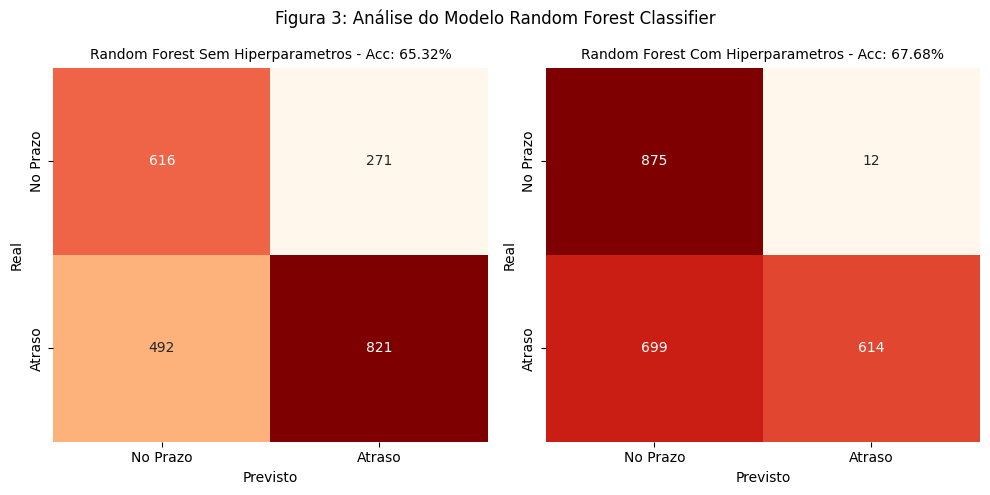

In [34]:
# Plotando a matriz de confusao - Sem Hiperparametros
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# Plotando a matriz de confusao
sns.heatmap(confusion_matrix(y_test, y_pred_rf_base), cmap='OrRd', annot=True, fmt='2.0f', 
              xticklabels=['No Prazo', 'Atraso'], yticklabels=['No Prazo', 'Atraso'], ax=axs[0], cbar=False)

acc = accuracy_score(y_test, y_pred_rf_base).round(4)
axs[0].set_title('Random Forest Sem Hiperparametros - Acc: %.2f%%' % (acc*100), fontsize=10)
axs[0].set_ylabel('Real')
axs[0].set_xlabel('Previsto')

# Plotando a matriz de confusao - Com Hiperparametros
sns.heatmap(confusion_matrix(y_test, y_pred_rf_otimizado), cmap='OrRd', annot=True, fmt='2.0f', 
              xticklabels=['No Prazo', 'Atraso'], yticklabels=['No Prazo', 'Atraso'], ax=axs[1], cbar=False)

acc = accuracy_score(y_test, y_pred_rf_otimizado).round(4)
axs[1].set_title('Random Forest Com Hiperparametros - Acc: %.2f%%' % (acc*100), fontsize=10)
axs[1].set_ylabel('Real')
axs[1].set_xlabel('Previsto')

# Titulo da figura
fig.suptitle('Figura 3: Análise do Modelo Random Forest Classifier', fontsize=12)

plt.tight_layout()

plt.show()

**Sobre a Figura**

O `modelo sem hiperparametro` claramente também sofreu de **overfitting**. O treino teve uma métrica de 100% e no teste cai para 65%, esta diferença é um exemplo claro de overfitting, isto se deve pela profundidade da arvore, ela ficou muito ajustada ao dados de treino, lembrando que Random Forest é modelo ensemble 'bagging' de modelos de Decision Tree.

A respeito do `modelo com hiperparametro` ele também não possui o problema de overfitting, mas tambem não conseguiu lidar bem com a predição da classe em *Atraso*, por este motivo, o modelo teve uma performance ruim com apenas 68% de acuracia.

## 2.4 Comparando os modelos

In [35]:
# Importando a biblioteca para calcular 'Specificity' e 'Sensibility'
from sklearn.metrics import roc_curve

In [36]:
# Retornando scores de cada modelo de machine learning treinada
y_prob_knn = knn_pipeline_best.predict_proba(X_test)[::,1]
y_prob_tree = tree_pipeline_best.predict_proba(X_test)[::,1]
y_prob_rf = rf_pipeline_best.predict_proba(X_test)[::,1]

In [37]:
# Tirando dos scores fpr = 1 - Taxa de Falsos Positivos (Especificidade)
# tpr = 1 - Taxa de Verdadeiros Positivos (Sensibilidade)
# Valores que compoem 
fpr1, tpr1, _ = roc_curve(y_test, y_prob_knn)
fpr2, tpr2, _ = roc_curve(y_test, y_prob_tree)
fpr3, tpr3, _ = roc_curve(y_test, y_prob_rf)

In [38]:
# Resultado das acuracia dos testes
auc1 = roc_auc_score(y_test, y_prob_knn).round(4)
auc2 = roc_auc_score(y_test, y_prob_tree).round(4)
auc3 = roc_auc_score(y_test, y_prob_rf).round(4)

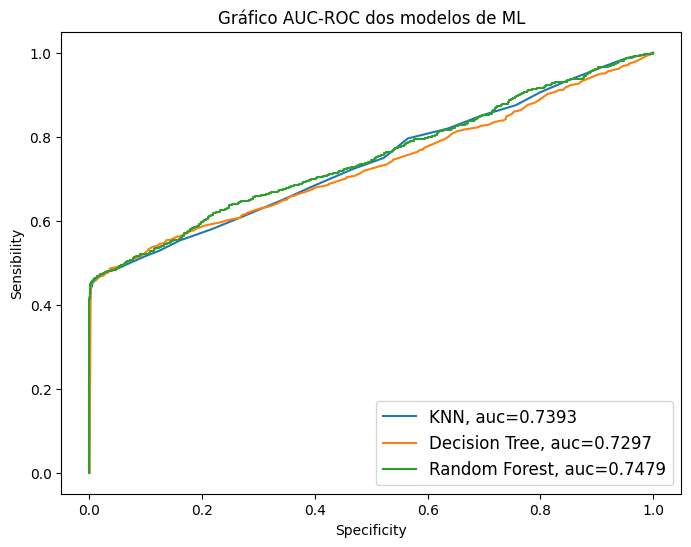

In [39]:
# Plotando a curva AUC-ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr1,tpr1,label="KNN, auc="+str(auc1))
plt.plot(fpr2,tpr2,label="Decision Tree, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Random Forest, auc="+str(auc3))
plt.legend(loc=4, fontsize=12)
plt.ylabel('Sensibility')
plt.xlabel('Specificity')
plt.title('Gráfico AUC-ROC dos modelos de ML')
plt.show()

**Comentários**

Falando especificamente dos modelos podemos notar que o modelo Random Forest se saiu melhor, é ele que tem os melhores números e no gráfico é ele que tem a maior area da curva, mas nota-se que o modelo Random Forest não tem uma grande diferença em relação aos outros modelos, depois do Random Forest, segue o KNN e por fim o Decision Tree, e de fato , o modelo Decision Tree dentre os três modelos é o pior.

Mas os três modelos são realmente parecidos, no geral, os modelos não desempenharam bem, claro não chega a ter uma previsão aleatória, mas também não tem uma forte predição, muito por conta da classe 1, os modelos não conseguem prever bem os dados que tem a entrega atrasada. Como já mencionamos os modelos tem em comum o erro de Falso-Positivo, isto é, o modelo prevê um registro que chegará no prazo, mas na verdade ele é uma entrega em atraso.

**O que pode ser feito..**

Podemos criar novas features para conseguir prever melhor as classes, se olharmos para os gráficos do notebook de visão geral, podemos notar que os registros da classe 'Em Atraso' estão bem mais distribuidos, enquanto os da classe 'No Prazo' estão com um padrão ou comportamento visivel; por esta razão o modelo não consegue aprender ou diferenciar com estas poucas features as classes target, sendo portanto necessário usar a etapa de *feature engineering*.